# Imports

In [1]:
PROJECT_DIR = "/Users/pluz999/Documents/Oxford/Thesis/queue-value"

import sys
sys.path.append(PROJECT_DIR)

import matplotlib
import os

from datetime import datetime, time, timedelta
from collections import defaultdict
from tqdm import tqdm
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab as pl

from scipy.sparse import csc_matrix, identity, linalg

from definitions import ROOT_DIR
from order_value.ImbalancePriceDeltaQueueOrderValue import ImbalancePriceDeltaQueueOrderValue
from orderbook_aggregator.ImbalancePriceDeltaQueueAggregator import ImbalancePriceDeltaQueueAggregator

# Set font

In [2]:
matplotlib.rc('font', family='Times New Roman') 
matplotlib.rc('text', usetex='false') 
matplotlib.rcParams.update({'font.size': 12})

# Global variables

In [3]:
csco_ticker = "CSCO"
csco_levels = 5
csco_start_date = datetime(2019,1,1)
csco_end_date = datetime(2019,1,31)

bac_ticker = "BAC"
bac_levels = 10
bac_start_date = datetime(2019,11,1)
bac_end_date = datetime(2019,11,27)

# Load and process order book data

In [4]:
csco_orderbooks: List[ImbalancePriceDeltaQueueAggregator] = []
for d in tqdm(pd.date_range(csco_start_date, csco_end_date)):
    try:
        csco_orderbooks.append(ImbalancePriceDeltaQueueAggregator(d, csco_ticker, csco_levels, spread_size=100))
    except FileNotFoundError:
        continue

100%|██████████| 31/31 [38:59<00:00, 75.48s/it]  


In [5]:
bac_orderbooks: List[ImbalancePriceDeltaQueueAggregator] = []
for d in tqdm(pd.date_range(bac_start_date, bac_end_date)):
    try:
        bac_orderbooks.append(
            ImbalancePriceDeltaQueueAggregator(
                d, bac_ticker, bac_levels, spread_size=100, queue_position_step_size=2_000, max_queue_position = 20_000
            )
        )
    except FileNotFoundError:
        continue

100%|██████████| 27/27 [15:19<00:00, 34.07s/it]


# Order book analysis

In [6]:
bac_orderbooks[0].orderbook.head().drop(
    columns=["next_imbalance", "prev_mid_move", "next_spread", "limit_buy", "limit_sell"]
)

,ask_price_0,ask_size_0,bid_price_0,bid_size_0,imbalance,spread,mid_price,mid_price_move,mid_price_delta,next_mid_price_delta,cancel_buy,cancel_sell,market_buy,market_sell
datetime,,,,,,,,,,,,,,
2019-11-01 09:45:01.300,313900,800,313800,4509,0.75,100,313850.0,0.0,-0.0,-0.0,0.0,100.0,0.0,0.0
2019-11-01 09:45:01.400,313900,700,313800,4509,0.75,100,313850.0,0.0,-0.0,-0.0,300.0,0.0,0.0,0.0
2019-11-01 09:45:01.500,313900,900,313800,4409,0.75,100,313850.0,0.0,-0.0,-0.0,0.0,0.0,0.0,0.0
2019-11-01 09:45:01.600,313900,900,313800,4409,0.75,100,313850.0,0.0,-0.0,-0.0,400.0,4200.0,0.0,0.0
2019-11-01 09:45:01.700,313900,900,313800,4109,0.75,100,313850.0,0.0,-0.0,-0.0,0.0,400.0,0.0,0.0


In [7]:
non_clipped_orderbook = (
    bac_orderbooks[0].raw_orderbook.copy().drop_duplicates(["datetime"], keep="last").set_index("datetime")
)
non_clipped_orderbook = non_clipped_orderbook.reindex(bac_orderbooks[0].time_steps(), method="ffill")
non_clipped_orderbook["mid_price_move"] = (
    non_clipped_orderbook["mid_price"].shift(-1) - non_clipped_orderbook["mid_price"]
)
non_clipped_orderbook["mid_price_delta"] = bac_orderbooks[0]._calculate_raw_mid_price_delta(non_clipped_orderbook)

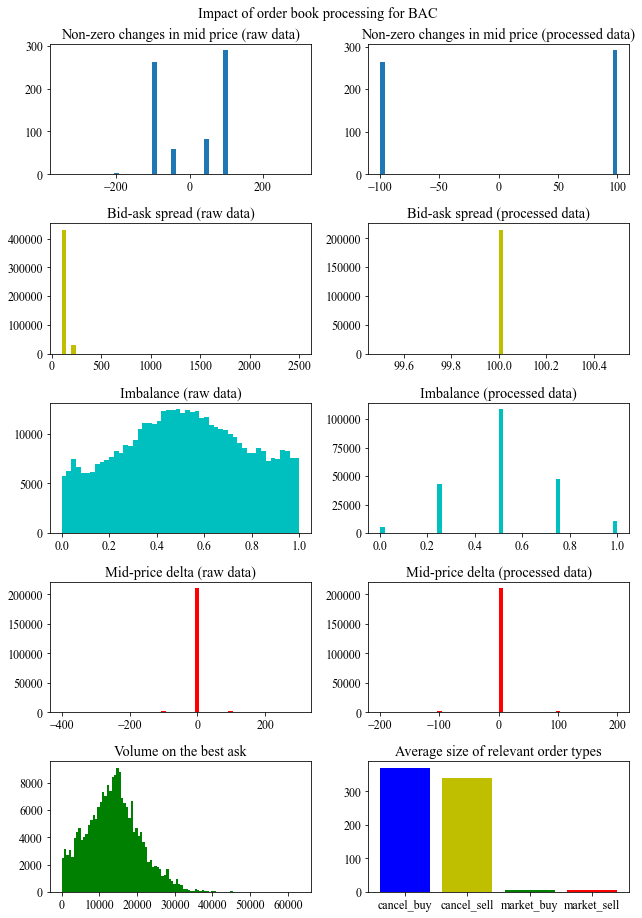

In [8]:
fig, ax = plt.subplots(5,2, figsize=(9,13))

ax[0,0].hist(non_clipped_orderbook[non_clipped_orderbook["mid_price_move"] != 0]["mid_price_move"] , bins=50)
ax[0,0].set_title("Non-zero changes in mid price (raw data)")

ax[0,1].hist(
    bac_orderbooks[0].orderbook[bac_orderbooks[0].orderbook["mid_price_move"] != 0]["mid_price_move"], bins=50
)
ax[0,1].set_title("Non-zero changes in mid price (processed data)")

ax[1,0].hist(bac_orderbooks[0].raw_orderbook["spread"], bins=50, color="y")
ax[1,0].set_title("Bid-ask spread (raw data)")

ax[1,1].hist(bac_orderbooks[0].orderbook["spread"], bins=50, color="y")
ax[1,1].set_title("Bid-ask spread (processed data)")

ax[2,0].hist(bac_orderbooks[0].raw_orderbook["imbalance"], bins=50, color="c")
ax[2,0].set_title("Imbalance (raw data)")

ax[2,1].hist(bac_orderbooks[0].orderbook["imbalance"], bins=50, color="c")
ax[2,1].set_title("Imbalance (processed data)")

ax[3,0].hist(non_clipped_orderbook["mid_price_delta"], bins=50, color="r")
ax[3,0].set_title("Mid-price delta (raw data)")

ax[3,1].hist(bac_orderbooks[0].orderbook["mid_price_delta"], bins=50, color="r")
ax[3,1].set_title("Mid-price delta (processed data)")

ax[4,0].hist(bac_orderbooks[0].orderbook["ask_size_0"], bins=100, color="g")
ax[4,0].set_title("Volume on the best ask")

my_colors = ['b', 'y', 'g', 'r']
ax[4,1].bar(
    ["cancel_buy", "cancel_sell", "market_buy", "market_sell"],
    (
        bac_orderbooks[0].orderbook[["cancel_buy", "cancel_sell", "market_buy", "market_sell"]].sum() / 
        len(bac_orderbooks[0].orderbook)
    ), 
    color=my_colors
)
ax[4,1].set_title("Average size of relevant order types")

fig.suptitle("Impact of order book processing for BAC")
fig.tight_layout()
fig.subplots_adjust(top=0.94)

plt.show()

# Queue value analysis

### Calculate micro-price

In [9]:
csco_microprices = pd.read_csv(
    os.path.join(ROOT_DIR, "models", "csco_micro_price.csv"), index_col=[0,1]
).values.T[0]

bac_microprices = pd.read_csv(
    os.path.join(ROOT_DIR, "models", "bac_micro_price.csv"), index_col=[0,1]
).values.T[0]

### Determine Markov chain probabilities

In [10]:
csco_queue_value = ImbalancePriceDeltaQueueOrderValue(csco_orderbooks, csco_microprices)

100%|██████████| 20/20 [2:12:27<00:00, 397.36s/it]  


In [11]:
bac_queue_value = ImbalancePriceDeltaQueueOrderValue(bac_orderbooks, bac_microprices)

100%|██████████| 19/19 [1:51:00<00:00, 350.56s/it]


### Plot $\delta$'s

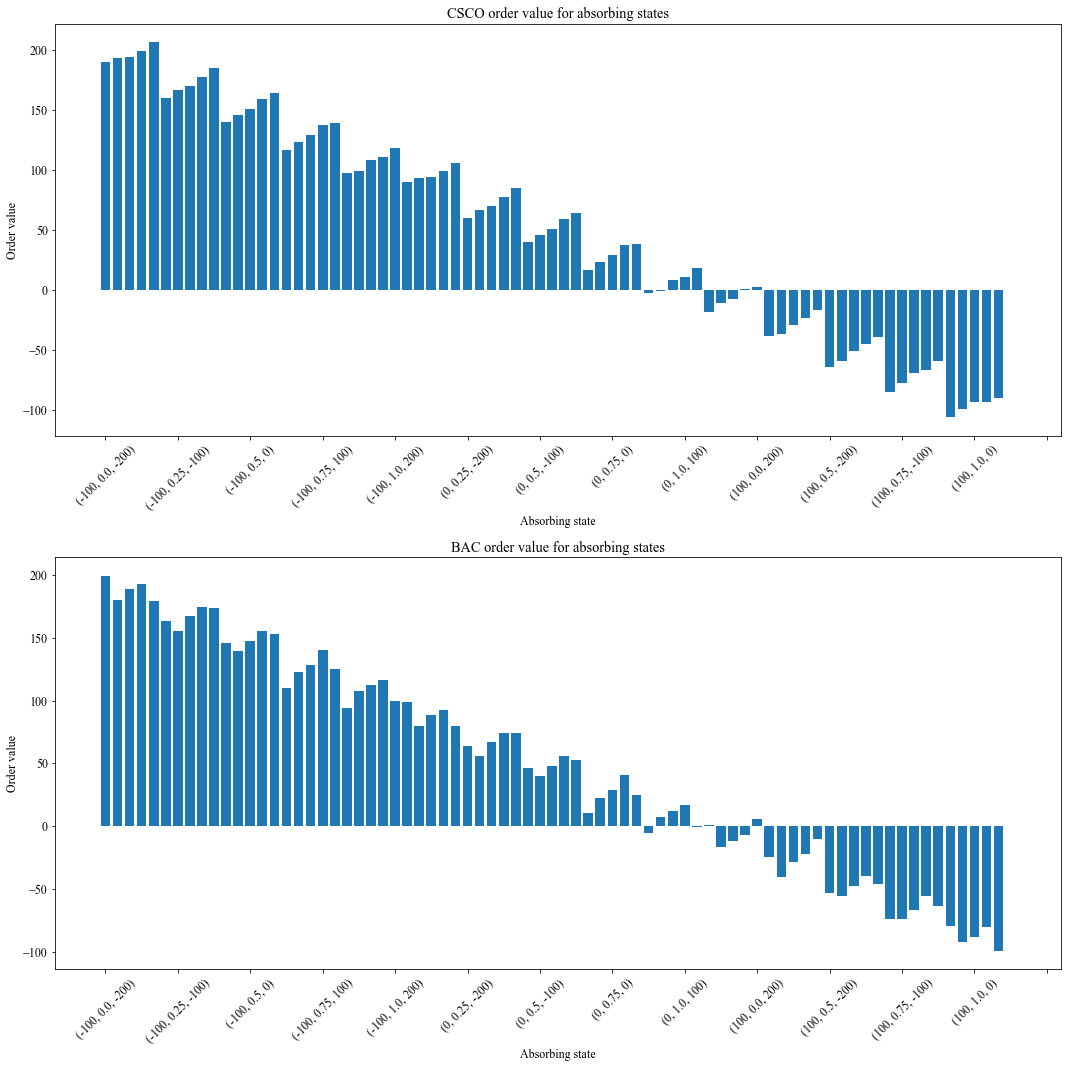

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(15,15))

ax[0].bar(
    [str((x[0], x[1], x[2])) for x in csco_queue_value.absorbing_prob_df.columns.values], 
    csco_queue_value.final_state_values
)
ax[0].set_title("CSCO order value for absorbing states")
ax[0].set_xlabel("Absorbing state")
ax[0].set_ylabel("Order value")
ax[0].xaxis.set_major_locator(plt.MaxNLocator(16))

ax[1].bar(
    [str((x[0], x[1], x[2])) for x in bac_queue_value.absorbing_prob_df.columns.values], 
    bac_queue_value.final_state_values
)
ax[1].set_title("BAC order value for absorbing states")
ax[1].set_xlabel("Absorbing state")
ax[1].set_ylabel("Order value")
ax[1].xaxis.set_major_locator(plt.MaxNLocator(16))

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)

fig.tight_layout()

plt.show()

### Investigate probabilities of state moves

In [13]:
csco_transient_sum = (
    identity(len(csco_queue_value.transient_prob_df.columns)).todense() - 
    csco_queue_value.transient_prob_df.values
)
csco_inv_trans_sum = pd.DataFrame(
    index=csco_queue_value.transient_prob_df.index,
    columns=csco_queue_value.transient_prob_df.columns,
    data=np.linalg.inv(csco_transient_sum)
).round(3)
csco_abs_delta_product = np.dot(csco_queue_value.absorbing_prob_df.values, csco_queue_value.final_state_values)

bac_transient_sum = (
    identity(len(bac_queue_value.transient_prob_df.columns)).todense() - 
    bac_queue_value.transient_prob_df.values
)
bac_inv_trans_sum = pd.DataFrame(
    index=bac_queue_value.transient_prob_df.index,
    columns=bac_queue_value.transient_prob_df.columns,
    data=np.linalg.inv(bac_transient_sum)
).round(3)
bac_abs_delta_product = np.dot(bac_queue_value.absorbing_prob_df.values, bac_queue_value.final_state_values)

In [14]:
bac_queue_value.absorbing_prob_df.to_csv(os.path.join(ROOT_DIR, "models", "bac_absorbing_probs.csv"))

In [15]:
bac_inv_trans_sum.to_csv(os.path.join(ROOT_DIR, "models", "bac_inv_trans_sum.csv"))

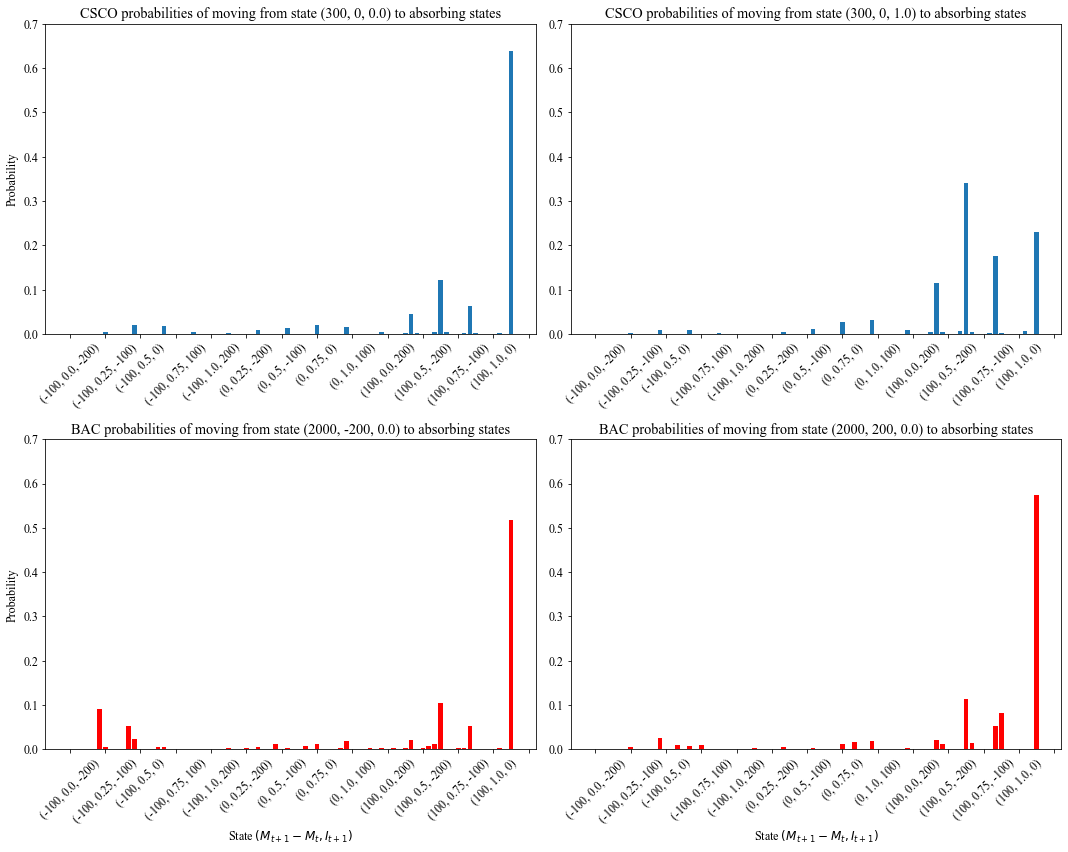

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(15,12))

ax[0, 0].bar(
    [str((x[0], x[1], x[2])) for x in csco_queue_value.absorbing_prob_df.columns.values], 
    np.dot(csco_inv_trans_sum.iloc[20].values, csco_queue_value.absorbing_prob_df.values)
)
ax[0, 0].set_title(
    f"CSCO probabilities of moving from state {csco_inv_trans_sum.iloc[20].name[1:][::-1]} to absorbing states"
)
ax[0, 0].set_ylabel("Probability")
ax[0, 0].xaxis.set_major_locator(plt.MaxNLocator(16))

ax[0, 1].bar(
    [str((x[0], x[1], x[2])) for x in csco_queue_value.absorbing_prob_df.columns.values], 
    np.dot(csco_inv_trans_sum.iloc[220].values, csco_queue_value.absorbing_prob_df.values)
)
ax[0, 1].set_title(
    f"CSCO probabilities of moving from state {csco_inv_trans_sum.iloc[220].name[1:][::-1]} to absorbing states"
)
ax[0, 1].xaxis.set_major_locator(plt.MaxNLocator(16))

ax[1, 0].bar(
    [str((x[0], x[1], x[2])) for x in bac_queue_value.absorbing_prob_df.columns.values], 
    np.dot(bac_inv_trans_sum.iloc[0].values, bac_queue_value.absorbing_prob_df.values),
    color="r"
)
ax[1, 0].set_title(
    f"BAC probabilities of moving from state {bac_inv_trans_sum.iloc[0].name[1:][::-1]} to absorbing states"
)
ax[1, 0].set_ylabel("Probability")
ax[1, 0].xaxis.set_major_locator(plt.MaxNLocator(16))
ax[1, 0].set_xlabel(r"State $(M_{t+1}-M_{t}, I_{t+1})$")

ax[1, 1].bar(
    [str((x[0], x[1], x[2])) for x in bac_queue_value.absorbing_prob_df.columns.values], 
    np.dot(bac_inv_trans_sum.iloc[40].values, bac_queue_value.absorbing_prob_df.values),
    color="r"
)
ax[1, 1].set_title(
    f"BAC probabilities of moving from state {bac_inv_trans_sum.iloc[40].name[1:][::-1]} to absorbing states"
)
ax[1, 1].xaxis.set_major_locator(plt.MaxNLocator(16))
ax[1, 1].set_xlabel(r"State $(M_{t+1}-M_{t}, I_{t+1})$")

plt.setp(ax[0,0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[0,1].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1,0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1,1].xaxis.get_majorticklabels(), rotation=45)

ax[0, 0].set_ylim([0, 0.7])
ax[0, 1].set_ylim([0, 0.7])
ax[1, 0].set_ylim([0, 0.7])
ax[1, 1].set_ylim([0, 0.7])

fig.tight_layout()

plt.show()

### Compute order values

In [17]:
csco_order_value_df = csco_queue_value.calculate_order_values()

bac_order_value_df = bac_queue_value.calculate_order_values()

In [18]:
csco_order_value_df.stack().stack().to_csv(os.path.join(ROOT_DIR, "models", "csco_order_value.csv"))

bac_order_value_df.stack().stack().to_csv(os.path.join(ROOT_DIR, "models", "bac_order_value.csv"))

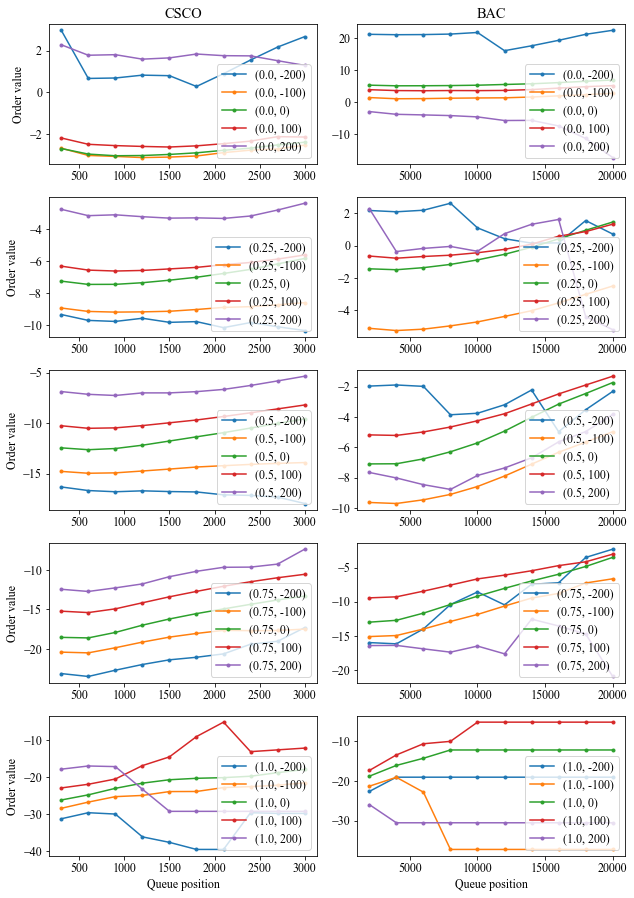

In [19]:
fig, ax = plt.subplots(5, 2, figsize=(9,13))

ax[0, 0].plot(csco_order_value_df.iloc[:, :5].replace(to_replace=0, method='ffill'), ".-")
ax[0, 0].legend(list(csco_order_value_df.iloc[:, :5].columns), loc="lower right")
ax[0, 0].set_title("CSCO")
ax[0, 0].set_ylabel("Order value")

ax[1, 0].plot(csco_order_value_df.iloc[:, 5:10].replace(to_replace=0, method='ffill'), ".-")
ax[1, 0].legend(list(csco_order_value_df.iloc[:, 5:10].columns), loc="lower right")
ax[1, 0].set_ylabel("Order value")

ax[2, 0].plot(csco_order_value_df.iloc[:, 10:15].replace(to_replace=0, method='ffill'), ".-")
ax[2, 0].legend(list(csco_order_value_df.iloc[:, 10:15].columns), loc="lower right")
ax[2, 0].set_ylabel("Order value")

ax[3, 0].plot(csco_order_value_df.iloc[:, 15:20].replace(to_replace=0, method='ffill'), ".-")
ax[3, 0].legend(list(csco_order_value_df.iloc[:, 15:20].columns), loc="lower right")
ax[3, 0].set_ylabel("Order value")

ax[4, 0].plot(csco_order_value_df.iloc[:, 20:25].replace(to_replace=0, method='ffill'), ".-")
ax[4, 0].legend(list(csco_order_value_df.iloc[:, 20:25].columns), loc="lower right")
ax[4, 0].set_xlabel("Queue position")
ax[4, 0].set_ylabel("Order value")

ax[0, 1].plot(bac_order_value_df.iloc[:, :5].replace(to_replace=0, method='ffill'), ".-")
ax[0, 1].legend(list(bac_order_value_df.iloc[:, :5].columns), loc="lower right")
ax[0, 1].set_title("BAC")

ax[1, 1].plot(bac_order_value_df.iloc[:, 5:10].replace(to_replace=0, method='ffill'), ".-")
ax[1, 1].legend(list(bac_order_value_df.iloc[:, 5:10].columns), loc="lower right")

ax[2, 1].plot(bac_order_value_df.iloc[:, 10:15].replace(to_replace=0, method='ffill'), ".-")
ax[2, 1].legend(list(bac_order_value_df.iloc[:, 10:15].columns), loc="lower right")

ax[3, 1].plot(bac_order_value_df.iloc[:, 15:20].replace(to_replace=0, method='ffill'), ".-")
ax[3, 1].legend(list(bac_order_value_df.iloc[:, 15:20].columns), loc="lower right")

ax[4, 1].plot(bac_order_value_df.iloc[:, 20:25].replace(to_replace=0, method='ffill'), ".-")
ax[4, 1].legend(list(bac_order_value_df.iloc[:, 20:25].columns), loc="lower right")
ax[4, 1].set_xlabel("Queue position")

fig.tight_layout()
fig.subplots_adjust(top=0.94)

plt.show()

### Order value breakdown

In [20]:
fill_probs = pd.DataFrame(
    index=bac_inv_trans_sum.index.droplevel(0),
    columns=["prob"]
)
fill_prob_dfs = []
for state in fill_probs.index:
    fill_prob_df = pd.DataFrame(
        columns=[bac_inv_trans_sum.loc[(0.0, state[0], state[1], state[2])].name],
        index=[str((x[0], x[1], x[2], x[3])) for x in bac_queue_value.absorbing_prob_df.columns.values],
        data=np.dot(
            bac_inv_trans_sum.loc[(0.0, state[0], state[1], state[2])].values, 
            bac_queue_value.absorbing_prob_df.values
        )
    )
    fill_prob_dfs.append(fill_prob_df)
    fill_probs.loc[state] = fill_prob_df.loc[
        [state for state in fill_prob_df.index if eval(state)[-1] != -1]
    ].sum().iloc[0]

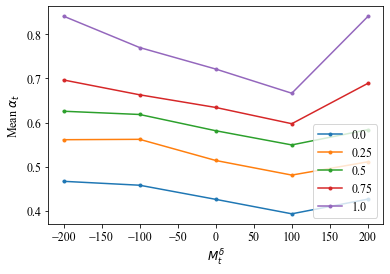

In [21]:
fig, ax = plt.subplots()

for imbalance in bac_orderbooks[0].imbalance_steps:
    # Filter out zeros as they are due to insufficient data
    ax.plot(fill_probs[fill_probs["prob"] != 0].loc[imbalance].unstack().mean(axis=1), ".-")

ax.legend(list(bac_orderbooks[0].imbalance_steps), loc="lower right")
ax.set_ylabel(r"Mean $\alpha_{t}$")
ax.set_xlabel(r"$M^{\delta}_{t}$")

plt.show()

In [22]:
liquidity_premium = pd.DataFrame(
    index=[
        str((state[1], state[2])) for state in bac_queue_value.absorbing_prob_df.columns.values if state[0]==0
    ], 
    columns=["liquidity_premium"],
    data=[50 - mp for mp in bac_microprices]
)

In [23]:
adverse_selection = -1 * bac_order_value_df.stack().stack().swaplevel(i=- 3, j=- 1).reindex(
    fill_probs.index
).divide(fill_probs["prob"])

for state in adverse_selection.index:
    adverse_selection.loc[state] += liquidity_premium.loc[str((state[0], state[1]))].values[0]

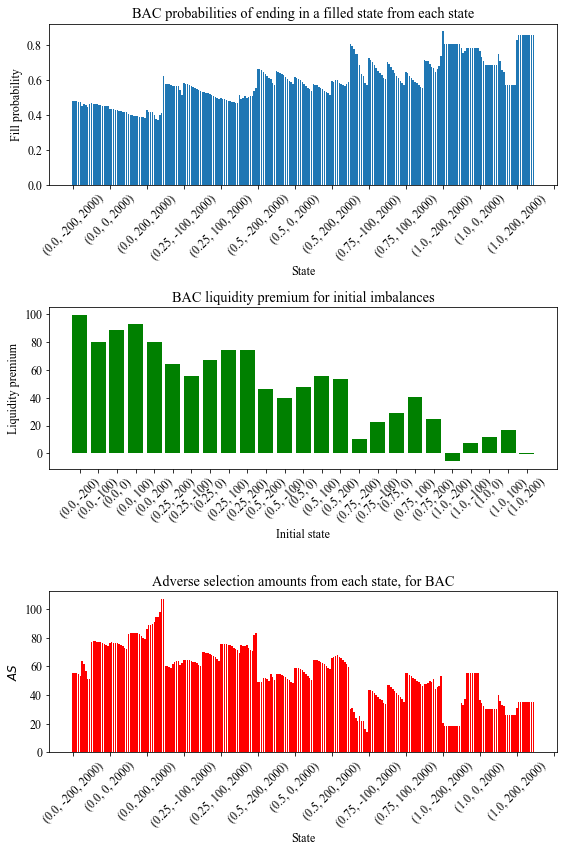

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(8,12))

ax[0].bar(
    [str(state) for state in fill_probs.index], 
    fill_probs.replace(to_replace=0, method="ffill").values.T[0]
)
ax[0].set_title(f"BAC probabilities of ending in a filled state from each state")
ax[0].set_xlabel("State")
ax[0].set_ylabel("Fill probability")
ax[0].xaxis.set_major_locator(plt.MaxNLocator(16))

ax[1].bar(
    liquidity_premium.index,
    liquidity_premium["liquidity_premium"],
    color="g"
)
ax[1].set_title("BAC liquidity premium for initial imbalances")
ax[1].set_xlabel("Initial state")
ax[1].set_ylabel("Liquidity premium")

ax[2].bar(
    [str(state) for state in adverse_selection.index], 
    adverse_selection.fillna(method="ffill").values,
    color="r"
)
ax[2].set_title(f"Adverse selection amounts from each state, for BAC")
ax[2].set_xlabel("State")
ax[2].set_ylabel(r"$AS$")
ax[2].xaxis.set_major_locator(plt.MaxNLocator(16))

plt.setp(ax[0].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=45)
plt.setp(ax[2].xaxis.get_majorticklabels(), rotation=45)

fig.tight_layout()

plt.show()